In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from numpy import sin, cos, sqrt, arccos, tan, arctan2, pi, arcsin, sinc

In [2]:
np.random.seed(438)

# Centroid of Points on the Surface of a Sphere

Tags: maths, pytorch

date: 2020-12-10T08:00:00+10:00

feature_image: /images/sphere_tangent_plane.png

<!--eofm-->

I've written a derivation of [how to find the centroid of a polygon on a sphere](https://skeptric.com/centroid-spherical-polygon/).
This post shows it explicitly in numerical computations, and also looks at the solution in [Spherical Averages and Applications to Spherical Splines and Interpolation, by Buss and Fillmore, *ACM Transactions on Graphics* 20, 95–126 (2001)](http://math.ucsd.edu/~sbuss/ResearchWeb/spheremean/).
Explicitly coding mathematics is a great exercise; having to concretely represent everything unearthed gaps in my understanding and found errors in both drafts of my derivation and the paper.

Given a set of points on a sphere we're trying to find the point that minimises the average distance from those points, which we'll call the centroid (or [Fréchet mean](https://en.wikipedia.org/wiki/Fr%C3%A9chet_mean)).

## Contents

### Part 1: Calculating the centroid

1. [Coordinate Transformations](#Coordinate-transformations) between spherical and cartesian coordinates
2. [Creating Random Points on the Sphere](#Creating-Random-Points-on-the-Sphere) for testing
3. [Geodesic Distance](#Geodesic-Distance) calculations
4. [Measuring the Centroid](#Measuring-the-Centroid) in terms of minimising the geodesic distance
5. [Iteratively Finding the Minimum](#Iteratively-finding-the-minimum) using a closed form solution

### Part 2: Implementing Buss and Filmore's approach

1. [The exponential map and its inverse](#The-exponential-map-and-its-inverse) calculated at the North Pole
2. [Rotating spheres](#Rotating-Spheres) to enable moving arbitrary points to the North Pole
3. [Exponential map at any point](#Exponential-map-at-any-point)
4. [Attempting to implement the algorithm](#Attempting-to-Implement-Algorithm-A1) (and failing to get it to work)

### Part 3: Gradient Descent with Pytorch

1. [Gradient Descent](#Gradient-Descent)

# Part 1: Calculating the centroid

## Coordinate transformations

To do calculations on the unit sphere we'll need some way of representing points on the sphere.
There's lots of possible representations (I normally like [Stereographic Projections](https://en.wikipedia.org/wiki/Stereographic_projection)), but we'll stick to two:

* Euclidean coordinate representation: (x,y,z) coordinates in 3-dimensional space.
* Latitude Longitude representation of places on a sphere.

To convert a latitude, from -π/2 to π/2 radians (i.e. 90°S to 90°N), and a longitude, from -π to π radians (i.e. 180°W to 180°E) to a coordinate we can use the following formula ([see Wikipedia for the Geometry](https://en.wikipedia.org/wiki/Spherical_coordinate_system#Cartesian_coordinates))

<img src="../static/images/spherical_coords.png" height="1000" width="500" />

In [3]:
def latlon_to_coord(lat, lon):
    return np.array([cos(lat) * cos(lon), cos(lat)*sin(lon), sin(lat)])

### Sanity checking coordinates

Let's make sure this gives reasonable results simple angles

So the north pole, (0,0,1) should be at π/2 latitude

In [4]:
latlon_to_coord(pi/2, 0)

array([6.123234e-17, 0.000000e+00, 1.000000e+00])

And the south pole, (0,0,-1), at -π/2 latitude

In [5]:
latlon_to_coord(-pi/2, 0)

array([ 6.123234e-17,  0.000000e+00, -1.000000e+00])

And the point on the x-axis (1,0,0) is at 0 latitude, and by convention 0 longitude

In [6]:
latlon_to_coord(0, 0)

array([1., 0., 0.])

The y-axis is at π/2 longitude

In [7]:
latlon_to_coord(0, pi/2)

array([6.123234e-17, 1.000000e+00, 0.000000e+00])

And at π longitude we have the other side of the x axis

In [8]:
latlon_to_coord(0, pi)

array([-1.0000000e+00,  1.2246468e-16,  0.0000000e+00])

Finally at π/4 longitude we should always have the x and y components equal

In [9]:
latlon_to_coord(0, pi/4)

array([0.70710678, 0.70710678, 0.        ])

In [10]:
latlon_to_coord(pi/4, pi/4)

array([0.5       , 0.5       , 0.70710678])

### Inverse Transformation: Cartesian Coordinates to Latitude and Longitude
Notice the use of [atan2](https://en.wikipedia.org/wiki/Atan2) to get the sign right.

In [11]:
def coord_to_latlon(x, y, z):
    assert np.all(np.abs((x*x +y*y +z*z) - 1) < 1e-5)
    lat = arcsin(z)
    lon = arctan2(y, x)
    return np.array([lat, lon])

### Sanity checking coordinates

Let's check the inverse of some of the examples above

In [12]:
coord_to_latlon(0,0,1)

array([1.57079633, 0.        ])

In [13]:
coord_to_latlon(0,0,-1)

array([-1.57079633,  0.        ])

In [14]:
coord_to_latlon(1,0,0)

array([0., 0.])

In [15]:
coord_to_latlon(0,1,0)

array([0.        , 1.57079633])

In [16]:
coord_to_latlon(0,-1,0)

array([ 0.        , -1.57079633])

In [17]:
coord_to_latlon(-1,0,0)

array([0.        , 3.14159265])

In [18]:
coord_to_latlon(1/sqrt(2),1/sqrt(2),0)

array([0.        , 0.78539816])

## Creating Random Points on the Sphere

For testing it's useful to be able to create random points on the sphere.
In this case I don't really care about the distribtution of the points so I will always just use a random uniform function.

I choose the coordinates as the first axis, and the points lie along the second axis. Either choice leads to awkwardness in places either in index access or broadcasting.

In [19]:
def random_latlon(n):
    return (np.random.random_sample([2, n]) - 0.5) * np.array([pi, 2*pi])[...,None]

Here are 5 points of latitude/longitude (the lat/lon is read vertically in the array below).

In [20]:
random_latlon(5)

array([[-1.05051377,  1.51919682,  1.08064898, -0.9478646 , -0.24458294],
       [ 0.51328911, -0.2909267 ,  0.70478098, -0.09613048, -1.45489469]])

The points are definitely in the right coordinate ranges; latitude between -pi/2 to pi/2 and longiture from -pi to pi

In [21]:
r = random_latlon(300)
r.min(axis=1), r.max(axis=1)

(array([-1.56325868, -3.10261397]), array([1.56479825, 3.11079206]))

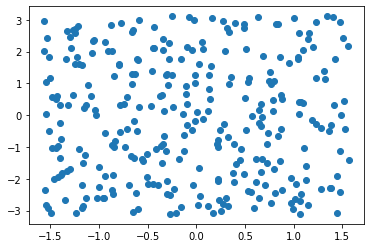

In [22]:
fig, ax = plt.subplots()
plt.scatter(r[0], r[1])

Similarly we can create a random point on the sphere by making a random point in the 3 dimensional unit cube centred on the origin and projecting it.
Note this will have a different distribution to the latitude longitude random points.

There is an infinitessimal chance this will blow up if we pick (0,0,0) as the random point.

In [23]:
def random_sphere_point(n):
    ans = np.random.random_sample([3, n]) - 0.5
    norm = np.sqrt((ans*ans).sum(axis=0))
    return ans / norm[...,:]

Here are 5 points on the sphere in Cartesian Coordinates

In [24]:
random_sphere_point(5)

array([[-0.7474551 , -0.67828974,  0.4894528 ,  0.14031347, -0.83906874],
       [ 0.12810391, -0.73422057,  0.46630495,  0.00811564,  0.15397168],
       [-0.65184374, -0.02903757,  0.73688239,  0.99007387, -0.52178191]])

Check they actually do lie on the unit sphere - a distance of 1 from the origin.

In [25]:
r = random_sphere_point(1000)
norms = (r*r).sum(axis=0)
norms.max(), norms.min()

(1.0000000000000004, 0.9999999999999996)

I guess that looks like a sphere

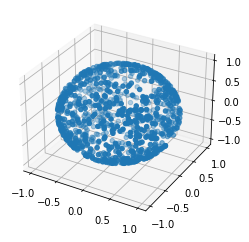

In [26]:
fig = plt.figure()
ax = plt.axes(projection='3d')
fig
ax.scatter3D(*r)

If we turn it a bit it still looks like a sphere

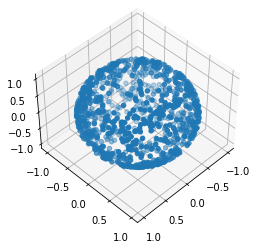

In [27]:
ax.view_init(45, 45)
fig

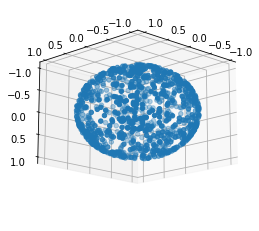

In [28]:
ax.view_init(165, 135)
fig

We can also project it back to lat-lon.

Notice how it's more concentrated towards the centre because there's actually less area in the extremites of latitude and longiture.

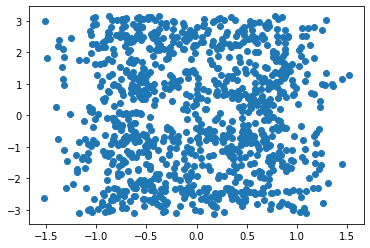

In [29]:
fig, ax = plt.subplots()
plt.scatter(*coord_to_latlon(*r))

Now let's check that our coordinate transforms are actually inverses by checking a bunch of random points.

It looks like the coordinate transforms are really inverses

In [30]:
def distance(x, y, axis=0):
    return sqrt((np.power(x - y, 2)).sum(axis=axis))

In [31]:
r = random_latlon(1000)
rr = coord_to_latlon(*latlon_to_coord(*r))
distance(rr, r).max()

5.484501741648273e-14

In [32]:
r = random_sphere_point(1000)
rr = latlon_to_coord(*coord_to_latlon(*r))
distance(rr, r).max()

1.3087313122991207e-15

## Geodesic Distance

I claim that the geodesic distance of two points on a sphere is the arccos of the dot product of the vectors that make them.

[According to Wikipedia](https://en.wikipedia.org/wiki/Great-circle_distance) the distance between two points is:

$$ \Delta\sigma = \arccos\bigl(\sin\phi_1\sin\phi_2 + \cos\phi_1\cos\phi_2\cos(\Delta\lambda)\bigr). $$

Where $\lambda_1, \phi_1$ and $\lambda_2, \phi_2$ are the longitude and latitude respectively.

Although this is numerically unstable let's check this to see if we're in the right ballpark

In [33]:
lat1, lon1 = random_latlon(10)
lat2, lon2 = random_latlon(10)

In [34]:
def latlon_geodist(lat1, lon1, lat2, lon2):
    return  arccos(sin(lat1) * sin(lat2) + cos(lat1) * cos(lat2) * cos(lon2 - lon1))

Let's do some sanity checking

Points at the same place should be 0 distance

In [35]:
latlon_geodist(lat1, lon1, lat1, lon1)

<ipython-input-34-30a781f9625f>:2: RuntimeWarning: invalid value encountered in arccos
  return  arccos(sin(lat1) * sin(lat2) + cos(lat1) * cos(lat2) * cos(lon2 - lon1))


array([0.00000000e+00, 1.49011612e-08, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00,            nan,
       0.00000000e+00, 0.00000000e+00])

It's possible to get a nan due to floating point error.
This rounds up to just over 1 which is just outside the bounds of arccos.

In [36]:
lat, lon = (-1.129680862943046, -1.4351343458834227)
sin(lat) * sin(lat) + cos(lat) * cos(lat) * cos(lon - lon)

1.0000000000000002

Let's hack this a little to make it more stable

In [37]:
def latlon_geodist(lat1, lon1, lat2, lon2, eps = 1e-6):
    dotprod = sin(lat1) * sin(lat2) + cos(lat1) * cos(lat2) * cos(lon2 - lon1)
    assert ((-1 - eps) <= dotprod).all() and (dotprod <= (1 + eps)).all()
    dotprod = dotprod.clip(-1, 1)
    return arccos(dotprod)

In [38]:
latlon_geodist(lat, lon, lat, lon)

0.0

The distance between the equator and the north pole should be pi/2

In [39]:
latlon_geodist(0, 0, pi/2, 0)

1.5707963267948966

The distance between antipodal points should be pi

In [40]:
latlon_geodist(-pi/2, 0, pi/2, 0)

3.141592653589793

In [41]:
latlon_geodist(0, 0, 0, pi)

3.141592653589793

In [42]:
latlon_geodist(0, -pi/2, 0, pi/2)

3.141592653589793

Now compare the geodistance with the arccos of the dot product

In [43]:
dist = latlon_geodist(lat1, lon1, lat2, lon2)
dist

array([2.46947963, 2.49913914, 1.46664046, 1.17041288, 0.37746113,
       2.16346273, 1.00909388, 0.48192531, 2.53874702, 2.6748886 ])

In [44]:
p = latlon_to_coord(lat1, lon1)
q = latlon_to_coord(lat2, lon2)

In [45]:
dist2 = arccos((p*q).sum(axis=0))
dist2

array([2.46947963, 2.49913914, 1.46664046, 1.17041288, 0.37746113,
       2.16346273, 1.00909388, 0.48192531, 2.53874702, 2.6748886 ])

They agree to the order of floating point error.

In [46]:
(dist - dist2).max()

0.0

Let's capture that in a function, again making sure to bound the elements to deal with floating point errors.

In [47]:
def geodist(x, y, eps=1e-6):
    dotprod = y.T @ x
    assert ((-1 - eps) <= dotprod).all() and (dotprod <= (1 + eps)).all()
    dotprod = dotprod.clip(-1, 1)
    return np.arccos(dotprod)

In [48]:
[geodist(pi, qi) for pi, qi in zip(p.T, q.T)] - dist

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In our function x can also be a collection of points:

In [49]:
q0 = np.array(q)[:,0]
q0

array([ 0.31287334, -0.20532369, -0.92733622])

In [50]:
[geodist(pi, q0) for pi in p.T]

[2.469479630515192,
 0.40323027521610894,
 1.4920173306523,
 1.9558900601514497,
 2.7359590483860647,
 2.1462847027999032,
 0.7043405473704512,
 2.7367906455922415,
 0.9539342223012038,
 1.2027484136227085]

In [51]:
geodist(p, q0)

array([2.46947963, 0.40323028, 1.49201733, 1.95589006, 2.73595905,
       2.1462847 , 0.70434055, 2.73679065, 0.95393422, 1.20274841])

They can also both be arrays in which case all pairing are calculated.

In [52]:
geodist(p, q)[:,0]

array([2.46947963, 0.34759067, 2.38907755, 0.89968604, 0.26041626,
       2.60671514, 1.83068643, 0.26215902, 1.62594305, 0.35150679])

## Measuring the Centroid

Suppose we have a bunch of points on the sphere, the centroid is the point that minimises the total (or equivalently average) distance from that point to all other points.

Let's try to find the centroid of 4 points.

In [53]:
m = random_sphere_point(1)[:,0]
ps = random_sphere_point(4)
m, ps

(array([ 0.61804667, -0.76357346, -0.18701308]),
 array([[ 0.93870158, -0.44268846,  0.68158944, -0.79466137],
        [-0.3443822 , -0.70496228,  0.34836305, -0.04389649],
        [ 0.01549958,  0.55412554,  0.64348973, -0.60546379]]))

In [54]:
dists = geodist(ps, m)
dists

array([0.57310037, 1.40903212, 1.53587692, 1.92238526])

In [55]:
dists.mean()

1.3600986701826971

In [56]:
lats, lons = coord_to_latlon(*ps)
mlat, mlon = coord_to_latlon(*m)

In [57]:
dists2 = latlon_geodist(lats, lons, mlat, mlon)
dists2

array([0.57310037, 1.40903212, 1.53587692, 1.92238526])

In [58]:
dists2.mean()

1.3600986701826971

The centroid minimises average distance.

We'll create a function that takes a collection of potential centroids to calculate the average distance from.

In [59]:
m[:,None]

array([[ 0.61804667],
       [-0.76357346],
       [-0.18701308]])

In [60]:
m.shape

(3,)

In [61]:
ps.shape

(3, 4)

In [62]:
def avg_distance(ps, m):
    # Allow m to be a vector *or* a matrix
    if len(m.shape) == 1:
        m = m[:, None]
    return geodist(ps, m).mean(axis=1)

In [63]:
avg_distance(ps, m)

array([1.36009867])

Let's do a random search for the centroid of the ps

In [64]:
m = random_sphere_point(50000)

In [65]:
distances = avg_distance(ps, m)
distances

array([1.87538182, 1.72981518, 1.83908373, ..., 1.53442742, 1.54397244,
       1.64161356])

Clearly the minimum *must* be lower than this.

In [66]:
m[:,distances.argmin()], distances.min(), distances.max()

(array([-0.43100664, -0.70535782,  0.56276427]),
 1.2565096068989563,
 1.8852477691126441)

Let's just check it's on the unit sphere.

In [67]:
min_point = m[:,distances.argmin()]
(min_point * min_point).sum()

0.9999999999999998

In [the notion parallax article](https://notionparallax.co.uk/2009/centroid-of-points-on-the-surface-of-a-sphere) the second suggestion is to project the average vector (which he says doesn't seem quite right).

We can check this explicity by calculating that projection.

In [68]:
avg = ps.sum(axis=1)
avg = avg / np.sqrt((avg*avg).sum())
meanpoint_dist = avg_distance(ps, avg[:,None])
avg, meanpoint_dist, meanpoint_dist <= distances.min()

(array([ 0.37007754, -0.7198562 ,  0.58723902]),
 array([1.29459946]),
 array([False]))

## Iteratively finding the minimum

As I derived in [finding the Centroid of a Spherical Polygon](/centroid-spherical-polygon) it occurs where

$$ c = k \sum_{i=1}^{N} \frac{p_i}{\sqrt{1 - (c \cdot p_i)^2}} $$

We can evaluate this iteratively and hope that it converges to the minimum.

In [69]:
def improve_centroid(c, ps):
    ans = (ps / sqrt(1 - np.power(c@ps, 2))).sum(axis=-1)
    norm = sqrt(ans @ ans)
    return ans / norm

In [70]:
improve_centroid(avg, ps)

array([ 0.23688037, -0.81413966,  0.53015498])

In [71]:
def fixpoint(f, x0, eps=1e-5, maxiter=1000, **kwargs):
    for _ in range(maxiter):
        x = f(x0, **kwargs)
        if distance(x, x0) < eps:
            return x
        x0 = x
    raise Exception("Did not converge")

In [72]:
def spherical_centroid(ps, eps=1e-5, maxiter=10000):
    return fixpoint(improve_centroid, np.zeros((3,)), ps=ps, eps=eps, maxiter=maxiter)

In [73]:
fix = spherical_centroid(ps)
fix

array([-0.442657  , -0.70497373,  0.5541361 ])

This does seem to be lower than any of our random points

In [74]:
dmin = avg_distance(ps, fix)
dmin, dmin <= distances.min()

(array([1.2554998]), array([ True]))

Another good check is to see whether moving a small distance around this point increases the distance.

(Note the small distance needs to be a bit bigger than our eps above in deciding convergence)

In [75]:
fix_latlon = coord_to_latlon(*fix)

In [76]:
eps = 1e-4
xeps = np.array([eps, 0])
yeps = np.array([0, eps])
perturbations = np.array([latlon_to_coord(*(fix_latlon + x)) for x in 
                  [0, xeps, -xeps, yeps, -yeps]]).T
perturbations

array([[-0.442657  , -0.44262753, -0.44268646, -0.4425865 , -0.44272749],
       [-0.70497373, -0.7049268 , -0.70502066, -0.705018  , -0.70492947],
       [ 0.5541361 ,  0.55421934,  0.55405286,  0.5541361 ,  0.5541361 ]])

The minimum occurs at the first point, with no perturbation.

In [77]:
avg_distance(ps, perturbations)

array([1.2554998 , 1.25551318, 1.2555215 , 1.25550478, 1.25551945])

In [78]:
avg_distance(ps, perturbations).argmin()

0

# Part 2: Recreating Buss and Filmore's Approach

## The exponential map and its inverse

In the Buss and Filmore paper they talk about the exponential map and its inverse at the point (0,0,1).
The idea is that we are building a correspondence between moving in the tangent plane and moving in the sphere itself in a way that preserves distances.
Really this is just a special sort of parameterisation of the sphere that preserves distances.

<img src="../static/images/sphere_tangent_plane.png">

The exponential map from the north pole takes an (x,y) point on that plane and returns an (x,y,z) coordinate on the sphere's surface.

They give the formula (bottom of page 11):

$$ exp_{(0,0,1)} (x, y) = (x \frac{\sin r}{r}, y \frac{\sin r}{r}, \cos{r}) $$

Where $$ r = \sqrt{x^2 + y^2} $$ is the distance of the point on the tangent plane from where it touches the sphere.

In code (using sinc for numerical stability at 0)

In [79]:
def exp_northpole(x, y):
    r = sqrt(x*x + y*y)
    sincr = sinc(r/np.pi)
    return (x * sincr, y * sincr, cos(r))

So at the origin we should get the north pole

In [80]:
exp_northpole(0,0)

(0.0, 0.0, 1.0)

And if we move forward a bit in the x direction on the tangent plane we move along the x-axis in 3 space the same distance.

In [81]:
q = np.array([0,0,1])
p = exp_northpole(0.5,0)
p, geodist(p, q)

((0.479425538604203, 0.0, 0.8775825618903728), 0.4999999999999999)

And similar for the y-axis

In [82]:
q = np.array([0,0,1])
p = exp_northpole(0.0,0.3)
p, geodist(p, q)

((0.0, 0.29552020666133955, 0.955336489125606), 0.30000000000000016)

And if we move (0.3, -0.4) which by Pythagoras is a distance of 0.5

In [83]:
q = np.array([0,0,1])
p = exp_northpole(0.3,-0.4)
p, geodist(p, q)

((0.2876553231625218, -0.3835404308833624, 0.8775825618903728),
 0.4999999999999999)

Notice that we can wrap around the sphere

In [84]:
exp_northpole(0, np.pi)

(0.0, 1.2246467991473532e-16, -1.0)

In [85]:
exp_northpole(0, 2*np.pi)

(-0.0, -2.4492935982947064e-16, 1.0)

In [86]:
exp_northpole(0, 4*np.pi)

(-0.0, -4.898587196589413e-16, 1.0)

### The inverse of the exponential map

It's easy to calculate the inverse of the exponential map at the north pole, which they call l (for log), and they have the formula on page 12:

$$ l_{(0,0,1)}(x, y, z) = \left(x \frac{\theta}{\sin(\theta)}, y \frac{\theta}{\sin(\theta)}\right) $$

Where $$ \theta = \cos^{-1}(z) $$.

In [87]:
def log_northpole(x, y, z):
    theta = arccos(z)
    sinc_theta = sinc(theta / np.pi)
    return (x / sinc_theta, y/ sinc_theta)

First we should see the north pole itself should map to the origin

In [88]:
log_northpole(0,0,1)

(0.0, 0.0)

We can check a few points and that distances are preserved, e.g. the equator is a distance pi/2 away

In [89]:
log_northpole(0,1,0)

(0.0, 1.5707963267948966)

In [90]:
log_northpole(1,0,0)

(1.5707963267948966, 0.0)

And this point is pi/4 from the north pole

In [91]:
log_northpole(1/sqrt(2),0,1/sqrt(2))

(0.7853981633974483, 0.0)

The mapping fails at the south pole (because the exponential map can't make it there). This should actually be the point at infinity.

In [92]:
log_northpole(0,0,-1)

(0.0, 0.0)

But it should be a real inverse:

If we take points on the sphere they should go back to where they started

In [93]:
ps = random_sphere_point(5)
distance(ps, exp_northpole(*log_northpole(*ps)))

array([2.02487339e-15, 1.02967200e-15, 5.55111512e-17, 0.00000000e+00,
       0.00000000e+00])

Now the inverse will only work if we don't wrap around the sphere; that is we need to move less than pi in any direction.

In [94]:
npoint = 5
length = np.random.random(npoint) * pi
direction = np.random.random(npoint) * 2 * pi
xs, ys = length * cos(direction), length * sin(direction)
ts = np.array([xs, ys])
ts

array([[-0.04616066, -0.17607737,  0.53101022, -0.07972639,  0.45558742],
       [ 0.13898508, -0.86137675, -2.0428374 , -3.04819971,  1.10504611]])

In [95]:
distance(ts, log_northpole(*exp_northpole(*ts)))

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.46600946e-14,
       0.00000000e+00])

## Rotating Spheres

The paper doesn't have a formula for the exponential map and its inverse at other points, but we can work it out by rotating the sphere and then rotating it back.
This is inefficient, but gets us the right answer.

First we need a way of rotating the sphere.
This is [surpisingly complicated](https://en.wikipedia.org/wiki/Rotation_matrix), but given an axis represented by unit vector u and an angle theta we can do a rotation with the following matrix:

$$ R = \begin{bmatrix} 
\cos \theta +u_x^2 \left(1-\cos \theta\right) & u_x u_y \left(1-\cos \theta\right) - u_z \sin \theta & u_x u_z \left(1-\cos \theta\right) + u_y \sin \theta \\ 
u_y u_x \left(1-\cos \theta\right) + u_z \sin \theta & \cos \theta + u_y^2\left(1-\cos \theta\right) & u_y u_z \left(1-\cos \theta\right) - u_x \sin \theta \\ 
u_z u_x \left(1-\cos \theta\right) - u_y \sin \theta & u_z u_y \left(1-\cos \theta\right) + u_x \sin \theta & \cos \theta + u_z^2\left(1-\cos \theta\right)
\end{bmatrix} $$

In [96]:
def rot_matrix(u, t):
    ux, uy, uz = u
    cost = cos(t)
    sint = sin(t)
    return np.array([
 [cost+ux*ux*(1-cost), ux*uy*(1-cost)-uz*sint, ux*uz*(1-cost)+uy*sint],
 [uy*ux*(1-cost)+uz*sint, cost+uy*uy*(1-cost), uy*uz*(1-cost)-ux*sint],
 [uz*ux*(1-cost)-uy*sint, uz*uy*(1-cost)+ux*sint, cost+uz*uz*(1-cost)],
    ])

Sanity checking: A rotation of 0 should be identity

In [97]:
rot_matrix(random_sphere_point(1)[:,0],0)

array([[ 1., -0.,  0.],
       [ 0.,  1., -0.],
       [ 0.,  0.,  1.]])

A rotation about the z-axis should be in the xy-plane

In [98]:
rot_matrix((0,0,1), pi/6)

array([[ 0.8660254, -0.5      ,  0.       ],
       [ 0.5      ,  0.8660254,  0.       ],
       [ 0.       ,  0.       ,  1.       ]])

And reversing the axis should reverse the rotation

In [99]:
rot_matrix((0,0,-1), pi/6)

array([[ 0.8660254,  0.5      ,  0.       ],
       [-0.5      ,  0.8660254,  0.       ],
       [ 0.       ,  0.       ,  1.       ]])

And similarly a rotation about the x-axis should be in the y-z plane

In [100]:
rot_matrix((1,0,0), pi/6)

array([[ 1.       ,  0.       ,  0.       ],
       [ 0.       ,  0.8660254, -0.5      ],
       [ 0.       ,  0.5      ,  0.8660254]])

Let's check a random rotation

In [101]:
axis = random_sphere_point(1)[:,0]
angle = np.random.random_sample(1)[0] * pi
axis, angle

(array([ 0.39320147, -0.03521715,  0.91877764]), 0.8930289746904281)

In [102]:
R = rot_matrix(axis, angle)

Rotating the oposite way should invert it

In [103]:
Rinv = rot_matrix(axis, -angle)

This should be the identity matrix

In [104]:
R @ Rinv

array([[ 1.00000000e+00,  2.28238442e-17, -2.96906906e-17],
       [ 2.28238442e-17,  1.00000000e+00, -3.30265999e-17],
       [-2.96906906e-17, -3.30265999e-17,  1.00000000e+00]])

In [105]:
Rinv @ R

array([[ 1.00000000e+00,  9.75220593e-17, -7.54846245e-17],
       [ 9.75220593e-17,  1.00000000e+00, -3.69276604e-17],
       [-7.54846245e-17, -3.69276604e-17,  1.00000000e+00]])

Let's rotate some random points and check if it preserves distances

In [106]:
p1, p2 = random_sphere_point(2).T
p1, p2

(array([ 0.84651763, -0.45095389, -0.2829284 ]),
 array([ 0.07670365, -0.73056703, -0.67851925]))

In [107]:
geodist(p1, p2)

0.944244049404823

In [108]:
geodist(R@p1, R@p2)

0.9442440494048231

### Rotating to the north pole

If we want to rotate a point to the north pole we can:

1. Find the plane containing the centre of the sphere, the point and the north pole
2. Find an axis perpendicular to that plane
3. Calculate the angle between the sphere and the point
4. Rotate along that axis by that angle (being careful about orientation)

There's an easy way to calculate the perpendicular axis to two vectors in 3 dimensions; the [cross product](https://en.wikipedia.org/wiki/Cross_product) (or for differential geometers the [hodge dual of the wedge product](https://en.wikipedia.org/wiki/Cross_product#Cross_product_as_an_external_product)).

I always remember the definition of the cross product by the mnemonic `xyzxyz`; e.g. the first xyz tells us the x component is yz-zy, then we go a letter across to yzx and so the y component is zx-xz and finally for the z component.

In [109]:
def cross_product(u, v):
    ux,uy,uz = u
    vx,vy,vz = v
    return (uy*vz-uz*vy, uz*vx-ux*vz, ux*vy - uy*vx)

Let's check a [random example](https://www.mathsisfun.com/algebra/vectors-cross-product.html):

In [110]:
cross_product((2,3,4) , (5,6,7))

(-3, 6, -3)

Now we can use this to calculate a unit perpendicular vector

In [111]:
def norm(x, axis=0):
    return np.sqrt((x*x).sum(axis=axis))

In [112]:
def unit_perp(u, v):
    v = np.array(cross_product(u, v))
    return v / norm(v)

In [113]:
unit_perp((2,3,4) , (5,6,7))

array([-0.40824829,  0.81649658, -0.40824829])

In [114]:
north_pole = np.array((0,0,1))

In [115]:
def perp_to_north_pole(v):
    # Special handling for north/south pole here
    # Note the order is important for orientation
    return unit_perp(v, north_pole)

In [116]:
perp_to_north_pole((1,0,0))

array([ 0., -1.,  0.])

In [117]:
perp_to_north_pole((0,1,0))

array([1., 0., 0.])

In [118]:
perp_to_north_pole((0,1/np.sqrt(2),1/np.sqrt(2)))

array([1., 0., 0.])

Of course this will all explode if the two vectors are parallel (since then there's a whole plane of potential orthogonal vectors, you need to break the symmetry).

In [119]:
perp_to_north_pole((0,0,1)), perp_to_north_pole((0,0,-1))

<ipython-input-112-372364f14156>:3: RuntimeWarning: invalid value encountered in true_divide
  return v / norm(v)


(array([nan, nan, nan]), array([nan, nan, nan]))

In [120]:
def angle_to_north_pole(v, axis=0):
    return np.arccos((north_pole * v).sum(axis=axis))

Check some basic examples

In [121]:
angle_to_north_pole(np.array((0,0,1)))

0.0

In [122]:
angle_to_north_pole(np.array((0,0,-1)))

3.141592653589793

In [123]:
angle_to_north_pole(np.array((0,1,0)))

1.5707963267948966

In [124]:
angle_to_north_pole(np.array((1/sqrt(2),1/sqrt(2),0)))

1.5707963267948966

In [125]:
angle_to_north_pole(np.array((0, 1/sqrt(2),1/sqrt(2))))

0.7853981633974484

Lets check the rotation in action

In [126]:
p = random_sphere_point(1)[:,0]
p

array([-0.29445315, -0.46089653, -0.83718082])

In [127]:
theta = angle_to_north_pole(p)
axis = perp_to_north_pole(p)
axis, theta

(array([-0.84270333,  0.53837821,  0.        ]), 2.562904446655308)

Check that it's perpendicular and of unit norm

In [128]:
(axis * north_pole).sum(), (axis * p).sum(), (axis * axis).sum()

(0.0, 0.0, 1.0)

In [129]:
R = rot_matrix(axis, -theta)

And indeed it rotates to the north pole

In [130]:
distance(R @ p , north_pole)

1.0938523993656688

## Exponential map at any point

Now we can take the exponential map at any point by first rotating to the north pole, calculating the exponential map, and then rotating back.

Let's take some point on the sphere

In [131]:
p = random_sphere_point(1)[:,0]
p

array([-0.52085469, -0.70958405,  0.47455333])

And a random point on its tangent plane (not too far from the origin)

In [132]:
max_dist = pi
length = np.random.random(1) * max_dist
direction = np.random.random(1) * 2 * np.pi
tx, ty = length * cos(direction), length * sin(direction)

tx, ty

(array([-1.23956389]), array([1.68843737]))

Let's rotate it to the north pole

In [133]:
theta = angle_to_north_pole(p)
axis = perp_to_north_pole(p)
axis, theta

(array([-0.80613779,  0.59172786,  0.        ]), 1.076339808354696)

In [134]:
rot_matrix(axis, theta) @ p

array([8.32667268e-17, 0.00000000e+00, 1.00000000e+00])

The tangent plane doesn't change it's coordinatisation, so we can just calculate the exponential map.

In [135]:
q_rot = exp_northpole(tx, ty)
q_rot

(array([-0.51244602]), array([0.69801406]), array([-0.50017542]))

The distance is preserved by the exponential map

In [136]:
geodist(np.array([0,0,1]), np.array(q_rot)), np.sqrt(tx**2 + ty**2)

(array([2.09459767]), array([2.09459767]))

And now we need to rotate the sphere back

In [137]:
q = rot_matrix(axis, -theta) @ q_rot
q

array([[-0.33260114],
       [ 0.94302493],
       [-0.00897019]])

And we check the distances are preserved

In [138]:
geodist(p, q), np.sqrt(tx**2 + ty**2)

(array([2.09459767]), array([2.09459767]))

Putting this all together we get a function that calculates the expoential map at point p on the sphere, for vector t in its tangent space.

In [139]:
def exp(p, t):
    tx, ty = t
    theta = angle_to_north_pole(p)
    axis = perp_to_north_pole(p)
    
    q_rot = exp_northpole(tx, ty)
    q = rot_matrix(axis, -theta) @ q_rot
    return q

In [140]:
q = exp(p, (tx, ty))
q

array([[-0.33260114],
       [ 0.94302493],
       [-0.00897019]])

In [141]:
geodist(p, q), sqrt(tx*tx + ty*ty)

(array([2.09459767]), array([2.09459767]))

### Inverse expoenential map at any point

The logic is essentially the same for the inverse map, which we call log, except we perform the rotation *before* we apply the map.

In [142]:
def log(p, q):
    theta = angle_to_north_pole(p)
    axis = perp_to_north_pole(p)
    q_rot = rot_matrix(axis, theta) @ q
    
    t = log_northpole(*q_rot)
    return t

So at any point p the log should be the inverse of exp

In [143]:
t = np.array([tx,ty])

In [144]:
t, log(p, exp(p, t))

(array([[-1.23956389],
        [ 1.68843737]]),
 (array([-1.23956389]), array([1.68843737])))

In [145]:
q = random_sphere_point(1)[:,0]
q

array([0.21868918, 0.77422052, 0.59393403])

In [146]:
exp(p, log(p, q))

array([0.21868918, 0.77422052, 0.59393403])

# Attempting to Implement Algorithm A1

We finally have all the pieces we need to implement algorithm A1 on page 23 of the paper, at least for the special case d=2 and weights all equal to 1/n.

```
Algorithm A1:
Inputs: Points p1, ..., pn on S^d
        Non-negative weights w1, ..., wn with sum 1.
Output: The spherical weighted average of the inputs.
Initialization: Set q := sum(w * p) / norm(sum(w * p))
Main Loop:
For i = 1, ..., n
    Set p_i* := log(q, p_i)
Set u := sum(w_i * (p_i* - q), i=1..n)
Set q := exp(q, q + u).
If norm(u) is sufficiently small, output q and halt.
Otherwise continue looping.
```

In [147]:
ps = random_sphere_point(4)

In [148]:
def average_projection(ps, axis=-1):
    avg = ps.mean(axis=axis)
    n = norm(avg)
    return avg/n

In [149]:
q = average_projection(ps)
q

array([-0.96262568,  0.25959003,  0.07723227])

In [150]:
avg_distance(ps, q)

array([0.94612087])

In [151]:
p_tangent = np.array(log(q, ps))
p_tangent

array([[-0.95857123,  0.61845951, -0.00271409, -0.10243155],
       [ 1.59888405,  0.20774684, -0.09692084, -1.16640361]])

Note in `u := sum( w_i * (p_i* - q))` the `q` is actually the projection of q into the tangent space, which is the origin.
When the weights are equal this reduces to the mean.

So this reduces to `u := 1/n sum(p_i)`

In [152]:
u = p_tangent.mean(axis=1)
u

array([-0.11131434,  0.13582661])

In [153]:
q2 = exp(q, u)

In [154]:
avg_distance(ps, q2)

array([0.99423434])

Let's wrap this up in a function.

In [155]:
def step_A1(q, ps):
    p_tangent = np.array(log(q, ps))
    u = p_tangent.mean(axis=1)
    return exp(q, u)

In [156]:
def alg_A1(ps, eps=1e-5, maxiter=1000):
    return fixpoint(step_A1, average_projection(ps), ps=ps, eps=eps, maxiter=maxiter)

In [157]:
a1 = alg_A1(ps)
a1

array([-0.93352393,  0.3425671 , -0.10573959])

In [158]:
avg_distance(ps, a1)

array([1.00335339])

It has converged

In [159]:
p_tangent = np.array(log(a1, ps))
p_tangent.mean(axis=1)

array([-1.85819581e-06, -5.84658255e-07])

Something is wrong; I can actually find a closer point with random search, or my previous implementation!

I'm not sure whether I implemented the algorithm incorrectly, or whether the algorithm itself is incorrect.

In [160]:
avg_distance(ps, random_sphere_point(10000)).min(), avg_distance(ps, spherical_centroid(ps))

(0.9329403881785946, array([0.9276463]))

### What's going on here?

#### Checking the code

Ideally I'd compare it with the results of their [C++ code](http://math.ucsd.edu/~sbuss/ResearchWeb/spheremean/) but running gcc I get a bunch of errors that would take me some time to debug

```
> gcc SphereMean.cpp
In file included from SphereMean.h:32,
                 from SphereMean.cpp:28:
../VrMath/LinearR4.h:207:7: warning: extra qualification ‘Matrix4x4::’ on member ‘operator*=’ [-fpermissive]
  207 |  void Matrix4x4::operator*= (const Matrix4x4& B); // Matrix product
      |       ^~~~~~~~~
SphereMean.cpp: In function ‘Quaternion ComputeMeanQuat(long int, const Quaternion*, const double*, double, double)’:
SphereMean.cpp:236:34: error: no matching function for call to ‘VectorR4::VectorR4(const Quaternion&)’
  236 |   vvArray[i] = VectorR4( *(qq+i) );
      |                                  ^
In file included from SphereMean.h:32,
                 from SphereMean.cpp:28:
../VrMath/LinearR4.h:73:2: note: candidate: ‘VectorR4::VectorR4(double, double, double, double)’
   73 |  VectorR4( double xVal, double yVal, double zVal, double wVal )
      |  ^~~~~~~~
../VrMath/LinearR4.h:73:2: note:   candidate expects 4 arguments, 1 provided
../VrMath/LinearR4.h:72:2: note: candidate: ‘VectorR4::VectorR4()’
   72 |  VectorR4( ) : x(0.0), y(0.0), z(0.0), w(0.0) {}
      |  ^~~~~~~~
../VrMath/LinearR4.h:72:2: note:   candidate expects 0 arguments, 1 provided
../VrMath/LinearR4.h:55:7: note: candidate: ‘constexpr VectorR4::VectorR4(const VectorR4&)’
   55 | class VectorR4 {
      |       ^~~~~~~~
../VrMath/LinearR4.h:55:7: note:   no known conversion for argument 1 from ‘const Quaternion’ to ‘const VectorR4&’
../VrMath/LinearR4.h:55:7: note: candidate: ‘constexpr VectorR4::VectorR4(VectorR4&&)’
../VrMath/LinearR4.h:55:7: note:   no known conversion for argument 1 from ‘const Quaternion’ to ‘VectorR4&&’

```

#### Checking the proof

They claim that in Theorem 3, that by Lemma 2a that a spherical centroid will be a centroid in the tangent space.

I'm having a lot of trouble following their proof because they change and introduce notation so quickly, but we can try to validate this claim.

In [161]:
c = spherical_centroid(ps)

It doesn't seem to be the case

In [162]:
np.array(log(c, ps)).mean(axis=1)

array([-0.14373332,  0.20639589])

However it does preserve distances, so it seems likely to be the correct exponential map

In [163]:
np.sqrt((np.array(log(c, ps)) * np.array(log(c, ps))).sum(axis=0)).mean()

0.9276463013575129

In [164]:
avg_distance(ps, c)

array([0.9276463])

In [165]:
np.array(log(c, ps)).mean(axis=1)

array([-0.14373332,  0.20639589])

In [166]:
avg_distance(ps, c)

array([0.9276463])

## Outline of a method of checking

I think there's a way we could check this, but I have not taken the time to implement it.

The stereographic projection about any point, and it's inverse, are straightforward to implement with standard geometry of points, lines and spheres.
Some geometry shows that the stereographic projection of a circle maps the angle t to a point 2 tan(t/2).
So it follows that composing the stereographic projection by a function f(x) = 2 arctan(x/2) should give the exponential map.

We would check this gives the same results as above.

Using Pytorch we could start with latitude and longitude (as below) and project to cartesian coordinates and apply the inverse exponential map to get to the tangent plane.
Then we could check the formulas of lemma 2a.

# Part 3: Gradient Descent With Pytorch

## Gradient Descent

At the end of the day the paper's approach was just a form of gradient descent (which I couldn't get working).
But we can get an autograd library, like that in Pytorch, to calculate the gradients for us.
The only trick here is we need to choose sphere coordinates (otherwise it will tell us to go off the sphere, unless we use Lagrange multipliers).

In [167]:
import torch

In [168]:
def torch_latlon_geodist(lat1, lon1, lat2, lon2):
    return  torch.arccos(torch.sin(lat1) * torch.sin(lat2) + torch.cos(lat1) * torch.cos(lat2) * torch.cos(lon2 - lon1))

In [169]:
latlon_ps = torch.tensor(coord_to_latlon(*ps))
latlon_ps

tensor([[-0.7885,  0.6007,  0.0995,  0.1919],
        [ 0.9673,  2.4580,  2.9729, -2.2270]], dtype=torch.float64)

In [170]:
def centroid_gradient_descent(c, ps, lr=0.1):
    dist = torch_latlon_geodist(*c, *ps).mean()
    dist.backward()
    with torch.no_grad():
        c -= lr * c.grad
    c.grad.zero_()
    return c, dist.item()

In [171]:
def centroid_sphere_gd(ps, eps=1e-6, max_iter=1000, lr=0.01):
    c = ps.mean(axis=1).requires_grad_()
    dist = None
    for _ in range(max_iter):
        last_dist = dist
        c, dist = centroid_gradient_descent(c, ps, lr=lr)
        if last_dist and abs(dist - last_dist) < eps:
            return c.requires_grad_(False)
    raise Exception("Did not converge")

Using torch gradient descent

In [172]:
c2 = centroid_sphere_gd(latlon_ps)
c2

tensor([0.1012, 2.9704], dtype=torch.float64)

In [173]:
c2c = latlon_to_coord(*np.array(c2))
c2c, avg_distance(ps, c2c)

(array([-0.98034083,  0.16950631,  0.1009924 ]), array([0.92810049]))

In [174]:
c2.requires_grad_()

tensor([0.1012, 2.9704], dtype=torch.float64, requires_grad=True)

In [175]:
dist = torch_latlon_geodist(*c2, *latlon_ps).mean()
dist.backward()

In [176]:
torch_latlon_geodist(*latlon_ps, *c2).mean()

tensor(0.9281, dtype=torch.float64, grad_fn=<MeanBackward0>)

Closely matches our original function

In [177]:
c = spherical_centroid(ps)
c, avg_distance(ps, c)

(array([-0.98093006,  0.16703028,  0.09938358]), array([0.9276463]))